<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Transform-for-Survival-Analysis" data-toc-modified-id="Transform-for-Survival-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transform for Survival Analysis</a></span><ul class="toc-item"><li><span><a href="#Transform-Business-Code" data-toc-modified-id="Transform-Business-Code-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Transform Business Code</a></span></li><li><span><a href="#-Drop-Missing-Neighborhoods" data-toc-modified-id="-Drop-Missing-Neighborhoods-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span> Drop Missing Neighborhoods</a></span></li><li><span><a href="#-Calculate-Lifetime-and-Identify-Censored-Data" data-toc-modified-id="-Calculate-Lifetime-and-Identify-Censored-Data-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span> Calculate Lifetime and Identify Censored Data</a></span></li></ul></li><li><span><a href="#Kaplan-Meier-Survival-Analysis" data-toc-modified-id="Kaplan-Meier-Survival-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Kaplan-Meier Survival Analysis</a></span></li><li><span><a href="#-Cox-Proportional-Hazard-Model-" data-toc-modified-id="-Cox-Proportional-Hazard-Model--5"><span class="toc-item-num">5&nbsp;&nbsp;</span> Cox Proportional Hazard Model </a></span><ul class="toc-item"><li><span><a href="#Transform-Categorical-Variables" data-toc-modified-id="Transform-Categorical-Variables-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Transform Categorical Variables</a></span></li></ul></li></ul></div>

<h3>Overview

In this notebook we begin to apply survival analysis to predict the lifetime of a business based on the characteristics of a neighborhood.  Here we use the registered businesses dataset, which contains one row per business going back almost 200 years. In notebook 3.2 we use a subset of the business data representing businesses that have opened in 2000 or later, to which we have added additional features.  
Survival analysis is also called 'time to event' analysis

Here use the Lifelines library, which is:

-  Built on top of Pandas 
-  Internal plotting methods 
-  Simple and intuitive API 
-  Only focus is survival analysis

We use two models from this library this project
-  Kaplan-Meier - Estimating survival rates for specific populations
-  Cox Proportional Hazards Model - Survival Regression

What we are looking at is time-to-event data in the presence of censoring
- takes time into account (duration, or lifetime, from a given start time to an specified event) In this case it is the time from when a business opens to when it closes.
- differentiates between full information (business has closed prior to the time of interest and we know when it was closed, therefore have complete information about the duration)and censored information (the business is still open. The duration is the time since it opened until the present, but that is not complete information. This is a type of missing data.)

Survival Regression - Accounting for multiple predictor variables in estimating survival times
-  Can't use ordinary linear regression - You would either have to drop the censored subjects as missing data, or underestimate the duration
-  Can't use logistic regression because it can't take into account the time component
-  Can't use time series analysis because you are dealing with different start dates and durations, not calendar time




In [1]:
import os
import sys
import re
import time
import datetime

import pickle


module_path = os.path.abspath(os.path.join('./lib/'))

if module_path not in sys.path:   
    sys.path.append(module_path)
from utilities import *

import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point

import pandas as pd
import numpy as np
import numpy
import seaborn as sns

from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential

import matplotlib.pyplot as plt
%matplotlib inline 

import warnings;
warnings.simplefilter('ignore')

<h3>Load Data

In [2]:
def reload():
    #reload the latest version of the data, with most recent features added
    df = pd.read_csv('../tmp/reg_bus_with_zillow_rank_asof20190514.csv', low_memory = False)

    #convert dates
    df['dba_start'] = pd.to_datetime(df['dba_start']) 
    df['dba_end'] = pd.to_datetime(df['dba_end'])
    df['loc_start'] = pd.to_datetime(df['loc_start'])
    df['loc_end'] = pd.to_datetime(df['loc_end'])
    return df

df = reload()

<h3>Transform for Survival Analysis

This file contains additional transformations done for survival analysis. The original dataset remains the same for future additional types of modeling, as well as iterative data exploration, to help explain model results.

<h4>Transform Business Code

Business type is represented in the naic_code and naic_description fields. 
https://www.census.gov/eos/www/naics/


In [3]:
#extract primary (first listed) business code
naic = df['naic_code'].str.split('-', n=1, expand=True)
df['naic'] = naic[0]
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,yq_start,y_end,q_end,yq_end,dur,status,new_neighborhood,neighborhood_size,size_rank,naic
0,94123.0,28,San Francisco,3101 Laguna Apts,3101 Laguna St,.,.,"{'latitude': '37.799823', 'longitude': '-122.4...",San Francisco,CA,...,1993-Q3,9999,0.0,NaN,103,open,Marina,Medium,1124,5300
1,94116.0,52,San Francisco,Ideal Novak Corp,8 Mendosa Ave,.,.,"{'latitude': '37.748926', 'longitude': '-122.4...",San Francisco,CA,...,1968-Q4,9999,0.0,NaN,202,open,West of Twin Peaks,Medium,0,5300
2,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,1988-Q2,2013,4.0,2013-Q4,102,closed,Marina,Medium,1124,.
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,1988-Q2,2013,4.0,2013-Q4,102,closed,Marina,Medium,1124,.
4,94133.0,86,San Francisco,1601 Grant Apts,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,1968-Q4,2016,2.0,2016-Q2,190,closed,North Beach,Medium,5770,.


In [4]:
dfclosed = df[df.status == 'closed']
dfclosed.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,yq_start,y_end,q_end,yq_end,dur,status,new_neighborhood,neighborhood_size,size_rank,naic
2,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,1988-Q2,2013,4.0,2013-Q4,102,closed,Marina,Medium,1124,.
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,1988-Q2,2013,4.0,2013-Q4,102,closed,Marina,Medium,1124,.
4,94133.0,86,San Francisco,1601 Grant Apts,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,1968-Q4,2016,2.0,2016-Q2,190,closed,North Beach,Medium,5770,.
5,94133.0,86,San Francisco,1601 Grant Parking,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,2013-Q1,2016,2.0,2016-Q2,13,closed,North Beach,Medium,5770,.
10,94124.0,216,San Francisco,Abc Insurance,1727 Oakdale Ave,.,.,"{'latitude': '37.736139', 'longitude': '-122.3...",NaN,NaN,...,2002-Q4,2018,2.0,2018-Q2,62,closed,Bayview Hunters Point,Medium,0,.


<h4> Drop Missing Neighborhoods

In [5]:
missing_neighborhood_mask = df['new_neighborhood'] == '.'

In [6]:
dfgoodhoods = df[~missing_neighborhood_mask]

In [7]:
dfgoodhoods.shape

(194826, 39)

In [8]:
dfgoodhoods.columns

Index(['zip', 'certificate_number', 'city', 'dba_name',
       'full_business_address', 'lic', 'lic_code_description', 'location',
       'mail_city', 'mail_state', 'mail_zipcode', 'mailing_address_1',
       'naic_code', 'naic_code_description', 'neighborhood', 'ownership_name',
       'parking_tax', 'state', 'supervisor_district',
       'transient_occupancy_tax', 'ttxid', 'dba_start', 'dba_end', 'loc_start',
       'loc_end', 'lat', 'lon', 'y_start', 'q_start', 'yq_start', 'y_end',
       'q_end', 'yq_end', 'dur', 'status', 'new_neighborhood',
       'neighborhood_size', 'size_rank', 'naic'],
      dtype='object')

In [9]:
df = dfgoodhoods

In [10]:
df.y_end.head()

0    9999
1    9999
2    2013
3    2013
4    2016
Name: y_end, dtype: int64

In [11]:
df['y_end'] = df.apply(lambda row: 0 if row.y_end == 9999 else row.y_end, axis=1)

In [12]:
df[['y_start', 'y_end']].head(10)

,y_start,y_end
0,1993,0
1,1968,0
2,1988,2013
3,1988,2013
4,1968,2016
5,2013,2016
6,1968,0
7,2012,0
8,2013,0
9,1968,0


<h4> Calculate Lifetime and Identify Censored Data

Calculate lifetime columns for both years and quarters to be able to compare model results for both scenarios. 

In [13]:
#calculate how long a business has been open in quarters
def calc_duration(ys,qs,ye,qe):
    if ye==0:
        ye=2019
        qe=2
    d =(ye-ys)*4
    d += (qe-qs)
    if d < 0:
        d = abs(d)
    return int(d)

In [14]:
#calculate how long a business has been open in quarters
def calc_lifetime(ys,ye):
    if ye==0:
        ye=2019
    lifetime = (ye-ys)
    if lifetime < 0:
        print (f'ALERT***** BAD DATA  ys: {ys}, ye: {ye}, returning: {lifetime}')
        lifetime = 0
    return int(lifetime)

In [15]:
df['lifetime'] = df.apply(lambda row: calc_lifetime(row.y_start,
                                           row.y_end),
                       axis=1)

In [16]:
df['lifetime_qtrs'] = df.apply(lambda row: calc_duration(row.y_start,
                                          row.q_start,
                                          row.y_end,
                                          row.q_end),
                       axis=1)

In [17]:
df[['lifetime', 'lifetime_qtrs', 'y_start', 'y_end', 'q_start', 'q_end']].head()

,lifetime,lifetime_qtrs,y_start,y_end,q_start,q_end
0,26,103,1993,0,3,0.0
1,51,202,1968,0,4,0.0
2,25,102,1988,2013,2,4.0
3,25,102,1988,2013,2,4.0
4,48,190,1968,2016,4,2.0


In [18]:
df['lifetime'].describe()

count    194826.000000
mean          8.278941
std           9.824882
min           0.000000
25%           2.000000
50%           5.000000
75%          11.000000
max         170.000000
Name: lifetime, dtype: float64

In [19]:
df['lifetime_qtrs'].describe()

count    194826.00000
mean         33.01180
std          39.23214
min           0.00000
25%           8.00000
50%          20.00000
75%          43.00000
max         679.00000
Name: lifetime_qtrs, dtype: float64

Use box plots to identify the degree to which there are outliers in terms of lifetime

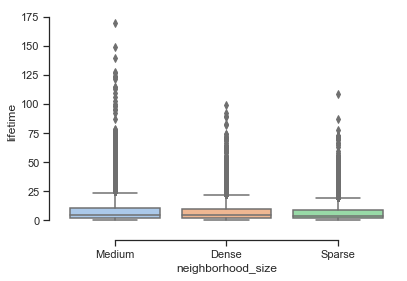

In [20]:
sns.set_context('poster')
sns.set(style="ticks", palette="pastel")

sns.boxplot(x='neighborhood_size', y='lifetime',
            data=df)
sns.despine(offset=10, trim=True);

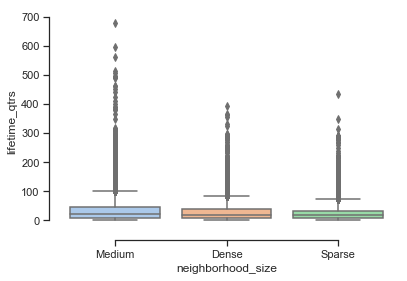

In [21]:
sns.boxplot(x='neighborhood_size', y='lifetime_qtrs',
            data=df);
sns.despine(offset=10, trim=True);

In [22]:
df['observed'] = df.apply(lambda row: 0 if row.status == 'open' else 1, axis=1)

In [23]:
#save again
df.to_csv('../tmp/reg_bus_sfonly_modeling_data_stg1_asof20190515.csv', index=False)

In [24]:
df = pd.read_csv('../tmp/reg_bus_sfonly_modeling_data_stg1_asof20190515.csv', low_memory = False)

In [25]:
df[['lifetime', 'lifetime_qtrs', 'observed', 'status', 'y_start', 'y_end', 'q_start', 'q_end']].head(10)

,lifetime,lifetime_qtrs,observed,status,y_start,y_end,q_start,q_end
0,26,103,0,open,1993,0,3,0.0
1,51,202,0,open,1968,0,4,0.0
2,25,102,1,closed,1988,2013,2,4.0
3,25,102,1,closed,1988,2013,2,4.0
4,48,190,1,closed,1968,2016,4,2.0
5,3,13,1,closed,2013,2016,1,2.0
6,51,202,0,open,1968,0,4,0.0
7,7,27,0,open,2012,0,3,0.0
8,6,22,0,open,2013,0,4,0.0
9,51,202,0,open,1968,0,4,0.0


In [26]:
df.y_start.describe()

count    194826.000000
mean       2009.307315
std           9.844563
min        1849.000000
25%        2007.000000
50%        2012.000000
75%        2015.000000
max        2019.000000
Name: y_start, dtype: float64

<h3>Kaplan-Meier Survival Analysis

Run the Kaplan-Meier analyis on two different granularities of lifetime: years (as lifetime), and quarters (as lifetime_qtrs)


In [27]:
#set parameters for km
T = df['lifetime']
TQ = df['lifetime_qtrs']
E = df['observed']


<br>
In years first....

Median lifetime in years = 12.0


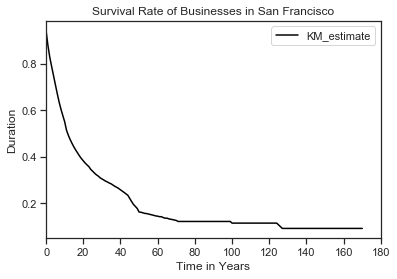

In [28]:
#fit based on years
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

print(f'Median lifetime in years = {kmf.median_}')
ax = kmf.survival_function_.plot(color='black')
                                                                                                                            
ax.set_xlabel("Time in Years")
ax.set_ylabel("Duration")
ax.set_xlim(0,180)

plt.title(f'Survival Rate of Businesses in San Francisco');


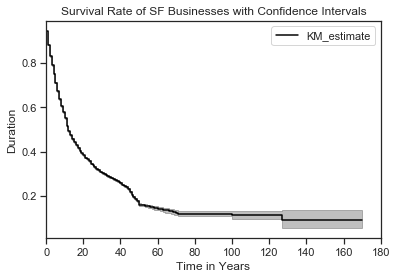

In [29]:
ax = kmf.plot(color='black') 
                                                                                                                            
ax.set_xlabel("Time in Years")
ax.set_ylabel("Duration")
ax.set_xlim(0,180)

plt.title(f'Survival Rate of SF Businesses with Confidence Intervals');

In [30]:
kmf.confidence_interval_[:5]

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.0,0.944123,0.942065
1.0,0.880912,0.878003
2.0,0.830432,0.827019
3.0,0.790484,0.786728
4.0,0.752036,0.747980
5.0,0.713058,0.708715


In [31]:
kmf.confidence_interval_[120:]

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
122.0,0.133395,0.096709
123.0,0.133395,0.096709
124.0,0.133395,0.096709
127.0,0.139684,0.054592
128.0,0.139684,0.054592
140.0,0.139684,0.054592
149.0,0.139684,0.054592
170.0,0.139684,0.054592


**Interpretation**
<br><br>
The y-axis represents the probability a business is still around after 𝑡 years or quarters, where 𝑡 time is on the x-axis. The median lifetime is 12 years, and very few businesses  make it past 50. The Kaplan-Meier model provides confidence intervals estimates in the call to fit, and can be located under the confidence_interval_ property. 
As shown above, we can call plot on the KaplanMeierFitter itself to plot both the KM estimate and its confidence
intervals.
<br><br>
Let's see how it looks when the timeline is more granular by using the quarters for the timeline

Alternatively, we can call plot on the KaplanMeierFitter itself to plot both the KM estimate and its confidence
intervals:

Median lifetime in quarters = 47.0


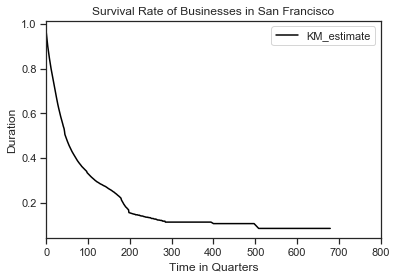

In [32]:
#fit based on quarters
kmf = KaplanMeierFitter()
kmf.fit(TQ, event_observed=E)

print(f'Median lifetime in quarters = {kmf.median_}')
ax = kmf.survival_function_.plot(color='black')
                                                                                                                              
ax.set_xlabel("Time in Quarters")
ax.set_ylabel("Duration")
ax.set_xlim(0,800)

plt.title(f'Survival Rate of Businesses in San Francisco');

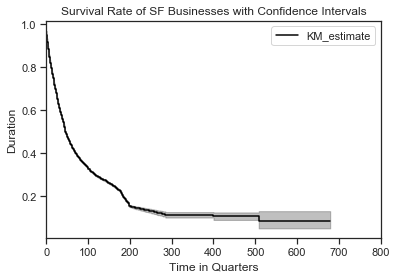

In [33]:
ax = kmf.plot(color='black') 
                                                                                                                            
ax.set_ylabel("Duration")
ax.set_xlabel("Time in Quarters") 
ax.set_xlim(0,800)

plt.title(f'Survival Rate of SF Businesses with Confidence Intervals');

In [34]:
kmf.confidence_interval_[:5] 

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.0,0.970017,0.968484
1.0,0.951997,0.950079
2.0,0.935404,0.933196
3.0,0.918096,0.915629
4.0,0.901370,0.898679
5.0,0.887068,0.884203


In [35]:
kmf.confidence_interval_[500:]  

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
508.0,0.131599,0.051367
512.0,0.131599,0.051367
561.0,0.131599,0.051367
597.0,0.131599,0.051367
679.0,0.131599,0.051367


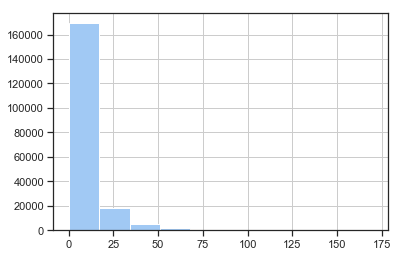

In [36]:
T.hist()

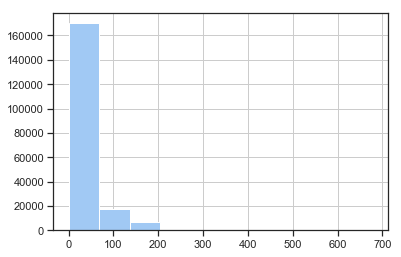

In [37]:
TQ.hist()

Let’s segment on other features to see what we can learn. Calling plot on either the estimate itself or the
fitter object will return an axis object, that can be used for plotting further estimates:

In [38]:
s = set(df.new_neighborhood)
len(s)

127

In [39]:
df.neighborhood_size.value_counts().head(20)

Medium    127689
Dense      49006
Sparse     18131
Name: neighborhood_size, dtype: int64

In [40]:
#####Slice the dataset by neighborhoods

mission = (df['new_neighborhood'] == "Mission")
soma = (df['new_neighborhood'] == 'South of Market')
northbeach = (df['new_neighborhood'] == 'North Beach')
findist = (df['new_neighborhood'] == 'Financial District/South Beach')
tenderloin = (df['new_neighborhood'] == "Tenderloin")
ir = (df['new_neighborhood'] == "Inner Richmond")


russianhill = (df['new_neighborhood'] == "Russian Hill")
pacheights = (df['new_neighborhood'] == "Pacific Heights")
hayes = (df['new_neighborhood'] == "Hayes Valley")
noe = (df['new_neighborhood'] == "Noe Valley")
marina = (df['new_neighborhood'] == "Marina")
ph = (df['new_neighborhood'] == "Presidio Heights")
bh = (df['new_neighborhood'] == "Bernal Heights")



###Slice the dataset by neighborhood size
sparse = (df['neighborhood_size'] == 'Sparse')
medium = (df['neighborhood_size'] == 'Medium')
dense = (df['neighborhood_size'] == 'Medium')

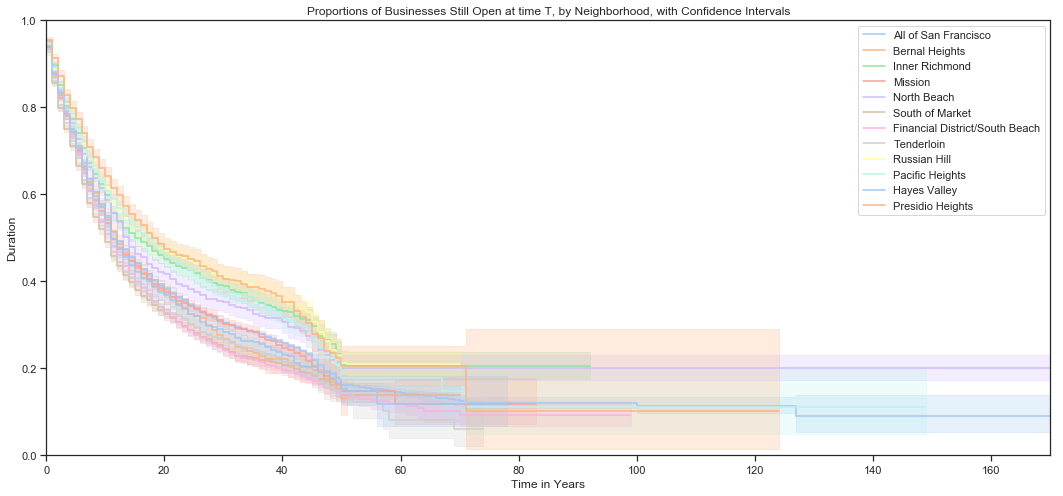

In [41]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)

kmf.fit(T, event_observed=E, label='All of San Francisco')
kmf.plot(ax=ax)

kmf.fit(T[bh], event_observed=E[bh], label='Bernal Heights')
kmf.plot(ax=ax)

kmf.fit(T[ir], event_observed=E[ir], label='Inner Richmond')
kmf.plot(ax=ax)

kmf.fit(T[mission], event_observed=E[mission], label='Mission')
kmf.plot(ax=ax)

kmf.fit(T[northbeach], event_observed=E[northbeach], label='North Beach')
kmf.plot(ax=ax)

kmf.fit(T[soma], event_observed=E[soma], label='South of Market')
kmf.plot(ax=ax)

kmf.fit(T[findist], event_observed=E[findist], label='Financial District/South Beach')
kmf.plot(ax=ax)

kmf.fit(T[tenderloin], event_observed=E[tenderloin], label='Tenderloin')
kmf.plot(ax=ax)

kmf.fit(T[russianhill], event_observed=E[russianhill], label='Russian Hill')
kmf.plot(ax=ax)

kmf.fit(T[pacheights], event_observed=E[pacheights], label='Pacific Heights')
kmf.plot(ax=ax)

kmf.fit(T[hayes], event_observed=E[hayes], label='Hayes Valley')
kmf.plot(ax=ax)

kmf.fit(T[ph], event_observed=E[ph], label='Presidio Heights')
kmf.plot(ax=ax)

ax.set_xlabel("Time in Years")
ax.set_ylabel("Duration")
plt.ylim(0, 1);
plt.title("Proportions of Businesses Still Open at time T, by Neighborhood, with Confidence Intervals");

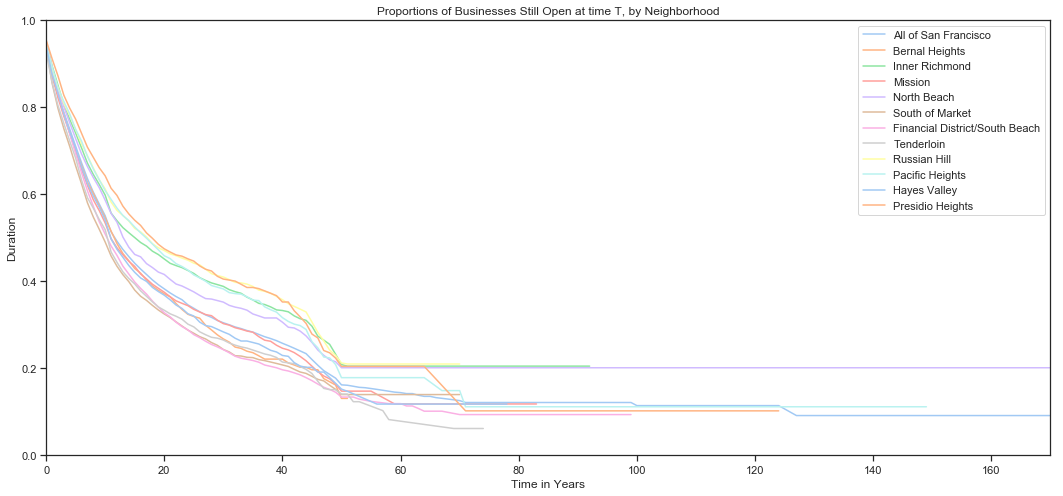

In [42]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)

kmf.fit(T, event_observed=E, label='All of San Francisco')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[bh], event_observed=E[bh], label='Bernal Heights')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[ir], event_observed=E[ir], label='Inner Richmond')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[mission], event_observed=E[mission], label='Mission')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[northbeach], event_observed=E[northbeach], label='North Beach')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[soma], event_observed=E[soma], label='South of Market')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[findist], event_observed=E[findist], label='Financial District/South Beach')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[tenderloin], event_observed=E[tenderloin], label='Tenderloin')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[russianhill], event_observed=E[russianhill], label='Russian Hill')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[pacheights], event_observed=E[pacheights], label='Pacific Heights')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[hayes], event_observed=E[hayes], label='Hayes Valley')
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[ph], event_observed=E[ph], label='Presidio Heights')
kmf.survival_function_.plot(ax=ax)

ax.set_xlabel("Time in Years")
ax.set_ylabel("Duration")
plt.ylim(0, 1);
plt.title("Proportions of Businesses Still Open at time T, by Neighborhood");

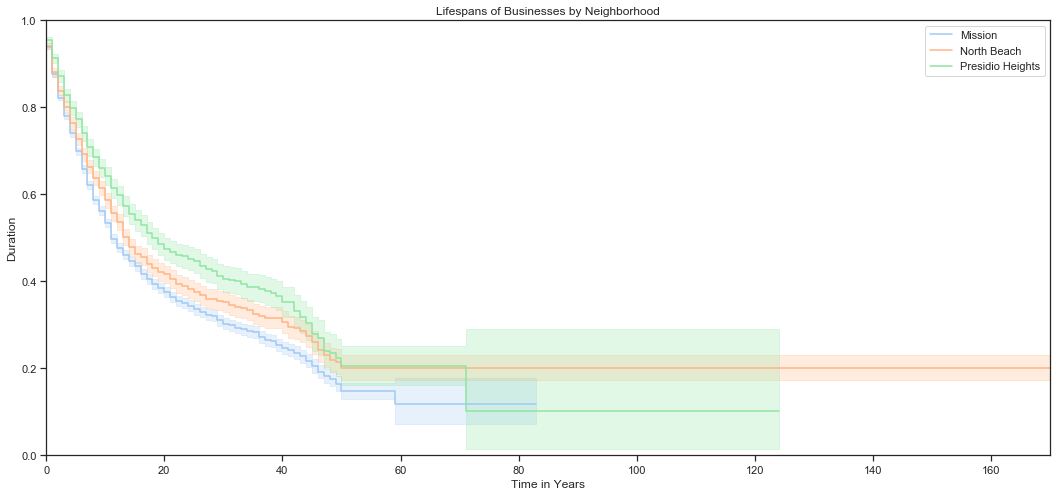

In [43]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)



# kmf.fit(T, event_observed=E, label='All of San Francisco')
# kmf.plot(ax=ax)


kmf.fit(T[mission], event_observed=E[mission], label='Mission')
kmf.plot(ax=ax)

kmf.fit(T[northbeach], event_observed=E[northbeach], label='North Beach')
kmf.plot(ax=ax)

# kmf.fit(T[soma], event_observed=E[soma], label='South of Market')
# kmf.plot(ax=ax)

# kmf.fit(T[findist], event_observed=E[findist], label='Financial District/South Beach')
# kmf.plot(ax=ax)

# kmf.fit(T[tenderloin], event_observed=E[tenderloin], label='Tenderloin')
# kmf.plot(ax=ax)

# kmf.fit(T[russianhill], event_observed=E[russianhill], label='Russian Hill')
# kmf.plot(ax=ax)

# kmf.fit(T[pacheights], event_observed=E[pacheights], label='Pacific Heights')
# kmf.plot(ax=ax)

# kmf.fit(T[hayes], event_observed=E[hayes], label='Hayes Valley')
# kmf.plot(ax=ax)

kmf.fit(T[ph], event_observed=E[ph], label='Presidio Heights')
kmf.plot(ax=ax)

ax.set_xlabel("Time in Years")
ax.set_ylabel("Duration")
plt.ylim(0, 1);
plt.title("Lifespans of Businesses by Neighborhood");

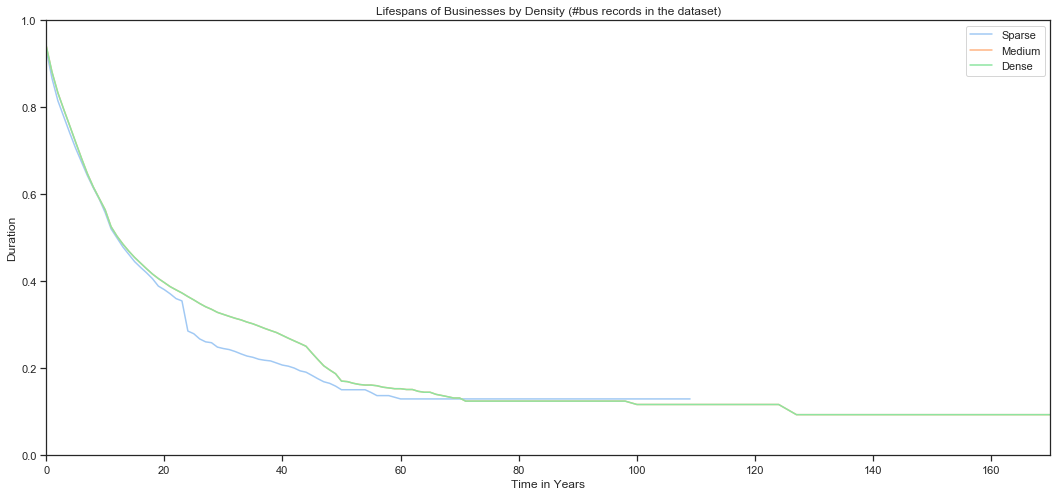

In [44]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)


kmf.fit(T[sparse], event_observed=E[sparse], label='Sparse')
#kmf.plot(ax=ax)
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[medium], event_observed=E[medium], label='Medium')
#kmf.plot(ax=ax)
kmf.survival_function_.plot(ax=ax)

kmf.fit(T[dense], event_observed=E[dense], label='Dense')
#kmf.plot(ax=ax)
kmf.survival_function_.plot(ax=ax)

plt.ylim(0, 1);
ax.set_ylabel("Duration")
ax.set_xlabel("Time in Years")
plt.title("Lifespans of Businesses by Density (#bus records in the dataset)");

In [45]:
t = np.linspace(0, 200, 20)

Median survival time of all businesses: 21.05263157894737
Median survival time of businesses in the mission: 21.05263157894737
Median survival time of businesses in North Beach: 14.0
Median survival time of businesses in SOMA: 10.526315789473685
Median survival time of businesses in the Financial District: 21.05263157894737
Median survival time of businesses in the Tenderloin: 21.05263157894737
Median survival time of businesses in Russian Hill: 21.05263157894737
Median survival time of businesses in Pacific Heights: 21.05263157894737
Median survival time of businesses in Hayes Valley: 21.05263157894737
Median survival time of businesses in Presidio Heights: 21.05263157894737
Median survival time of businesses in Inner Richmond: 21.05263157894737
Median survival time of businesses in Bernal Heights: 21.05263157894737


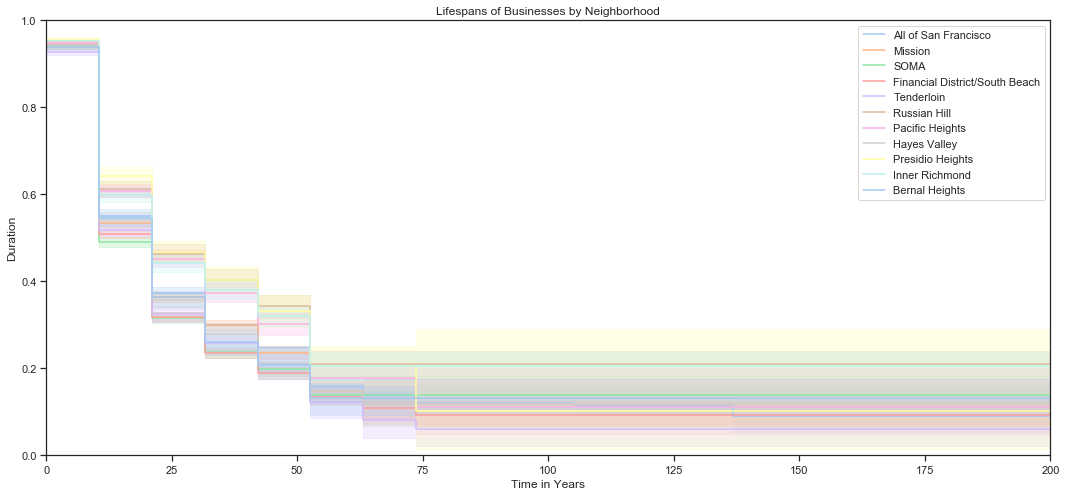

In [46]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)


kmf.fit(T, event_observed=E,  timeline=t,label='All of San Francisco')
kmf.plot(ax=ax)
print("Median survival time of all businesses:", kmf.median_)

kmf.fit(T[mission], event_observed=E[mission], timeline=t, label='Mission')
kmf.plot(ax=ax)
print("Median survival time of businesses in the mission:", kmf.median_)

kmf.fit(T[northbeach], event_observed=E[northbeach], label='North Beach')
# kmf.plot(ax=ax)
print("Median survival time of businesses in North Beach:", kmf.median_)

kmf.fit(T[soma], event_observed=E[soma], timeline=t, label='SOMA')
kmf.plot(ax=ax)
print("Median survival time of businesses in SOMA:", kmf.median_)

kmf.fit(T[findist], event_observed=E[findist], timeline=t, label='Financial District/South Beach')
kmf.plot(ax=ax)
print("Median survival time of businesses in the Financial District:", kmf.median_)

kmf.fit(T[tenderloin], event_observed=E[tenderloin], timeline=t, label='Tenderloin')
kmf.plot(ax=ax)
print("Median survival time of businesses in the Tenderloin:", kmf.median_)

kmf.fit(T[russianhill], event_observed=E[russianhill], timeline=t, label='Russian Hill')
kmf.plot(ax=ax)
print("Median survival time of businesses in Russian Hill:", kmf.median_)

kmf.fit(T[pacheights], event_observed=E[pacheights], timeline=t, label='Pacific Heights')
kmf.plot(ax=ax)
print("Median survival time of businesses in Pacific Heights:", kmf.median_)

kmf.fit(T[hayes], event_observed=E[hayes], timeline=t, label='Hayes Valley')
kmf.plot(ax=ax)
print("Median survival time of businesses in Hayes Valley:", kmf.median_)

kmf.fit(T[ph], event_observed=E[ph], timeline=t, label='Presidio Heights')
kmf.plot(ax=ax)
print("Median survival time of businesses in Presidio Heights:", kmf.median_)


kmf.fit(T[ir], event_observed=E[ir], timeline=t, label='Inner Richmond')
kmf.plot(ax=ax)
print("Median survival time of businesses in Inner Richmond:", kmf.median_)


kmf.fit(T[bh], event_observed=E[bh], timeline=t, label='Bernal Heights')
kmf.plot(ax=ax)
print("Median survival time of businesses in Bernal Heights:", kmf.median_)

plt.ylim(0, 1)

ax.set_ylabel("Duration")
ax.set_xlabel("Time in Years")
plt.title("Lifespans of Businesses by Neighborhood");

It seemed strange that the median was exactly the same for so many, but I tested in individual cells and verified it is indeed the case. There is actually a good explanation for this. The estimates are calculated at steps, 

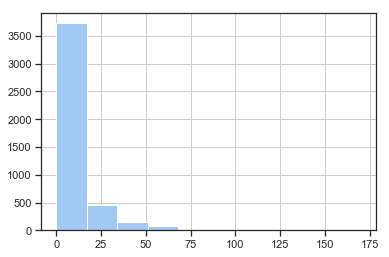

In [47]:
T[northbeach].hist()

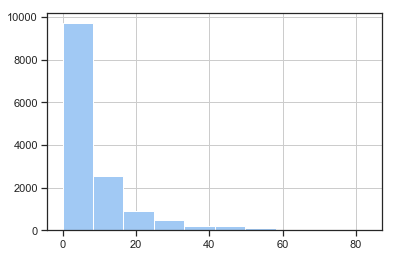

In [48]:
T[mission].hist()

In [49]:
T[northbeach].describe()

count    4431.000000
mean        9.313473
std        11.300468
min         0.000000
25%         2.000000
50%         5.000000
75%        12.000000
max       170.000000
Name: lifetime, dtype: float64

In [50]:
T[mission].describe()

count    14171.000000
mean         8.331734
std          9.929275
min          0.000000
25%          2.000000
50%          5.000000
75%         11.000000
max         83.000000
Name: lifetime, dtype: float64

In [51]:
T[pacheights].describe()

count    5411.000000
mean        9.725189
std        11.413958
min         0.000000
25%         2.000000
50%         6.000000
75%        13.000000
max       149.000000
Name: lifetime, dtype: float64

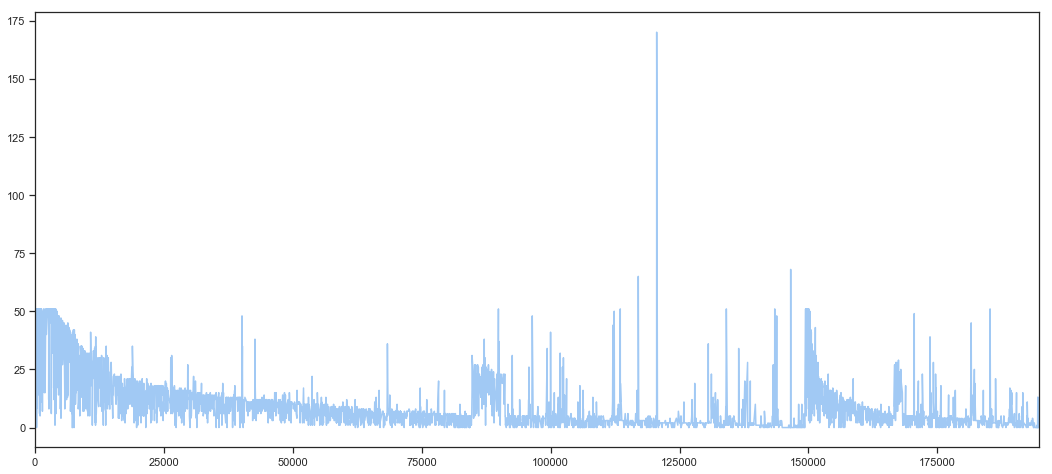

In [52]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)
T[northbeach].plot();

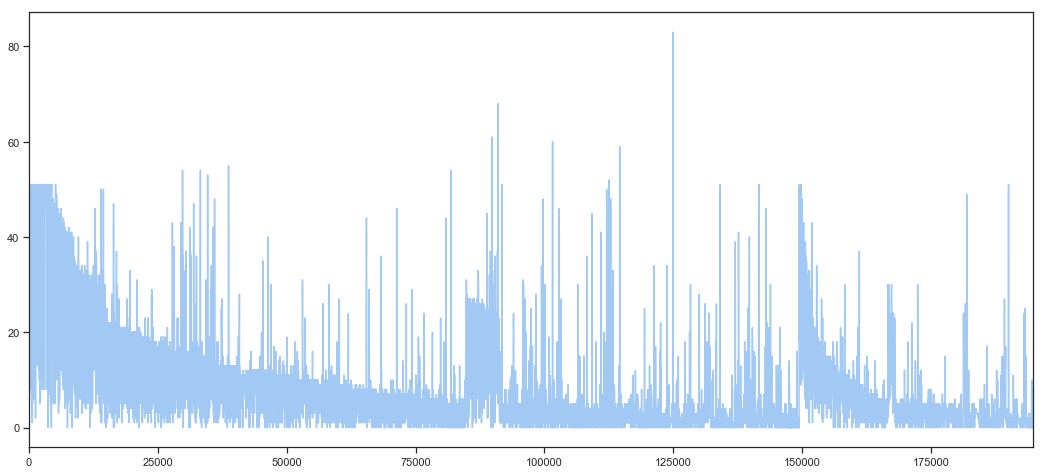

In [53]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)
T[mission].plot()

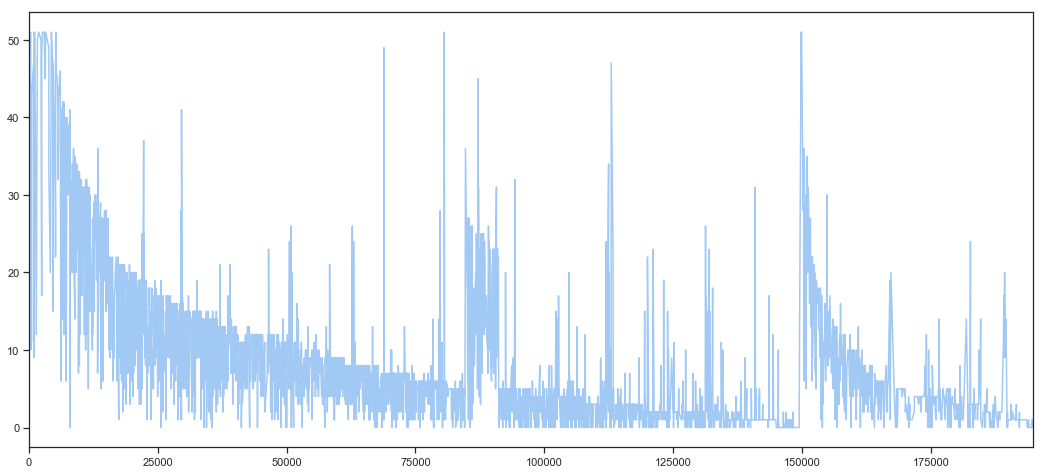

In [54]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)
T[bh].plot()

Trying to understand why the northbeach curve looks so different than the others. There are far fewer records, but I would think that would make a smoother line, not one with more granular steps.  When I look at in quarter, the interval frequency increases (naturally) and that is reflected in the step size. So, it seems that the thing with North Beach is that the durations are far more granular, meaning that for the other neighborhoods, there bigger gaps between the duration values. I wonder why that would be? 

The plots above have the index on the x-axis and the durations on the y-axis. So for northbeach the lifetime values are much smaller. It looks like it has only one long-lasting business!

Well it seems that the answer is the outlier. It is the oldest record in the dataset, representing the Marine Exchange of the San Francisco Bay Region, in business since September 1, 1849!

In [55]:
dftemp = df.sort_values(by='y_start', ascending=True)
dftemp.iloc[0]

zip                                                                94133.0
certificate_number                                                 1067085
city                                                         San Francisco
dba_name                   Marine Exchange Of The San Francisco Bay Region
full_business_address                                     505 Beach St 300
lic                                                                      .
lic_code_description                                                     .
location                                                               NaN
mail_city                                                    San Francisco
mail_state                                                              CA
mail_zipcode                                                         94133
mailing_address_1                                     505 Beach St Ste 300
naic_code                                                                .
naic_code_description    

This next block of code is used to quickly do a comparison of two different neighborhoods, plotting the curve, and printing the logrank_test results.


With the example in the docs the difference between survival functions is very obvious. Here though, the
curves are more similar, so it is beneficial to perform a statistical test. Lifelines contains routines in lifelines.statistics to compare two survival curves. Specifically, the function logrank_test is a common statistical test in survival analysis that compares two event series’ generators. If the value returned exceeds some pre-specified value, then we rule that the series have different generators.

Statistic logrank_test "measures and reports on whether two intensity processes are different. That is, given two
event series, determines whether the data generating processes are statistically different.
The test-statistic is chi-squared under the null hypothesis."

(reference: Lifelines documenation)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99

---
 test_statistic      p  -log2(p)
          48.36 <0.005     38.04
Median survival time of businesses in the mission: 52.631578947368425
Median survival time of businesses in SOMA: 42.10526315789474


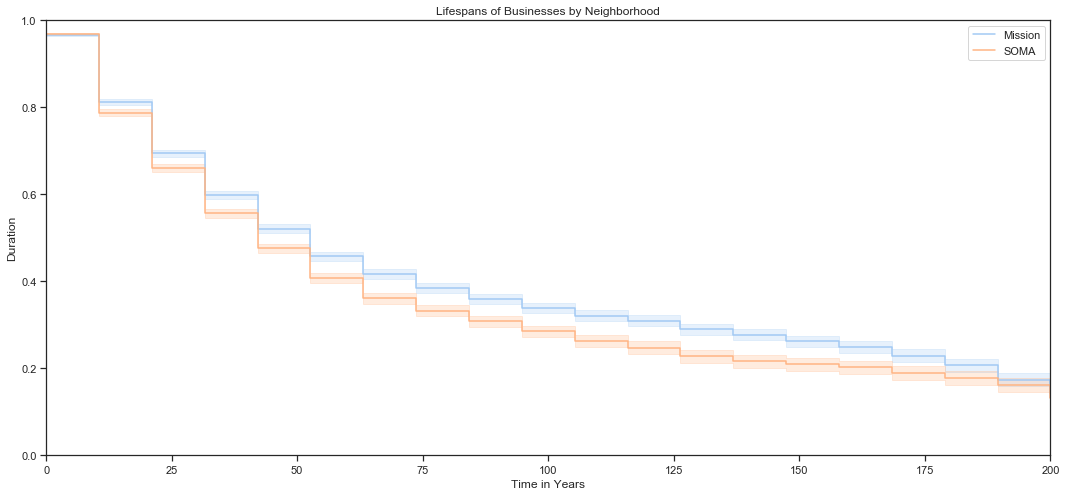

In [56]:
##future step - make this a function
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)

###### Change vals here     
results = logrank_test(T[mission], T[soma], E[mission], E[soma], alpha=.99)
results.print_summary()


####### ...and below

# kmf.fit(T, event_observed=E,  timeline=t,label='All of San Francisco')
# kmf.plot(ax=ax)
# print("Median survival time of all businesses:", kmf.median_)

kmf.fit(TQ[mission], event_observed=E[mission], timeline=t, label='Mission')
kmf.plot(ax=ax)
print("Median survival time of businesses in the mission:", kmf.median_)

# kmf.fit(TQ[northbeach], event_observed=E[northbeach], label='North Beach')
# kmf.plot(ax=ax)
# print("Median survival time of businesses in North Beach:", kmf.median_)

kmf.fit(TQ[soma], event_observed=E[soma], timeline=t, label='SOMA')
kmf.plot(ax=ax)
print("Median survival time of businesses in SOMA:", kmf.median_)

# kmf.fit(T[findist], event_observed=E[findist], timeline=t, label='Financial District/South Beach')
# kmf.plot(ax=ax)
# print("Median survival time of businesses in the Financial District:", kmf.median_)

# kmf.fit(T[tenderloin], event_observed=E[tenderloin], timeline=t, label='Tenderloin')
# kmf.plot(ax=ax)
# print("Median survival time of businesses in the Tenderloin:", kmf.median_)

# kmf.fit(T[russianhill], event_observed=E[russianhill], timeline=t, label='Russian Hill')
# kmf.plot(ax=ax)
# print("Median survival time of businesses in Russian Hill:", kmf.median_)

# kmf.fit(T[pacheights], event_observed=E[pacheights], timeline=t, label='Pacific Heights')
# kmf.plot(ax=ax)
# print("Median survival time of businesses in Pacific Heights:", kmf.median_)

# kmf.fit(T[hayes], event_observed=E[hayes], timeline=t, label='Hayes Valley')
# kmf.plot(ax=ax)
# print("Median survival time of businesses in Hayes Valley:", kmf.median_)

# kmf.fit(T[ph], event_observed=E[ph], timeline=t, label='Presidio Heights')
# kmf.plot(ax=ax)
# print("Median survival time of businesses in Presidio Heights:", kmf.median_)


plt.ylim(0, 1)

ax.set_xlabel("Time in Years")
ax.set_ylabel("Duration")
plt.title("Lifespans of Businesses by Neighborhood");

Median survival time of businesses in the sparse neighborhoods: 21.05263157894737
Median survival time of businesses in medium density neighborhoods 21.05263157894737
Median survival time of businesses in dense neighborhoods: 21.05263157894737


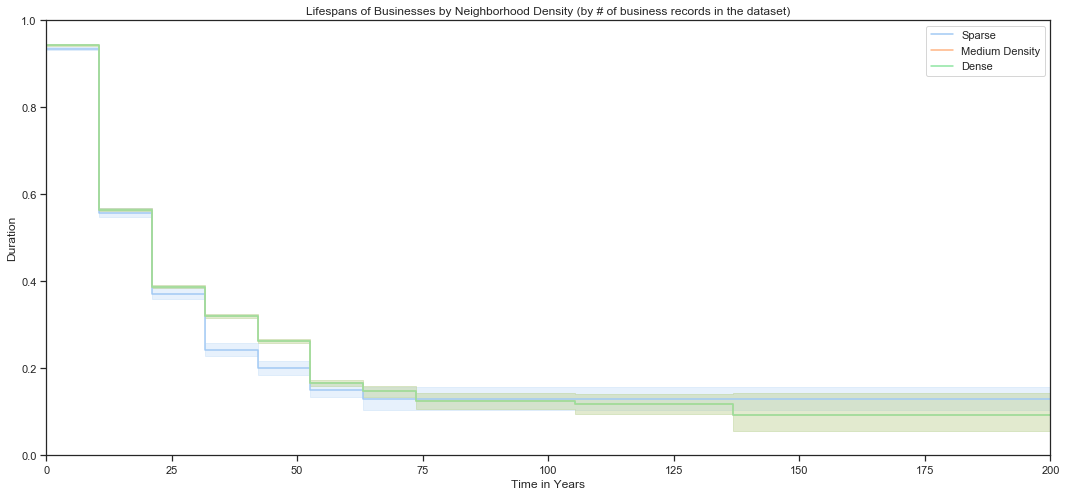

In [57]:
fig = plt.figure(figsize=(18,8))
ax = plt.subplot(111)

kmf.fit(T[sparse], event_observed=E[sparse], timeline=t, label='Sparse')
kmf.plot(ax=ax)
print("Median survival time of businesses in the sparse neighborhoods:", kmf.median_)

kmf.fit(T[medium], event_observed=E[medium], timeline=t, label='Medium Density')
kmf.plot(ax=ax)
print("Median survival time of businesses in medium density neighborhoods", kmf.median_)

kmf.fit(T[dense], event_observed=E[dense], timeline=t, label='Dense')
kmf.plot(ax=ax)
print("Median survival time of businesses in dense neighborhoods:", kmf.median_)


plt.ylim(0, 1)

ax.set_ylabel("Duration")
ax.set_xlabel("Time in Years")
plt.title("Lifespans of Businesses by Neighborhood Density (by # of business records in the dataset)");

In [58]:
#save again
df.to_csv('../tmp/reg_bus_sfonly_modeling_data_stg2_asof20190515.csv', index=False)

In [59]:
df = pd.read_csv('../tmp/reg_bus_sfonly_modeling_data_stg2_asof20190515.csv', low_memory = False)

In [60]:
n_size = ['Sparse', 'Medium', 'Dense']

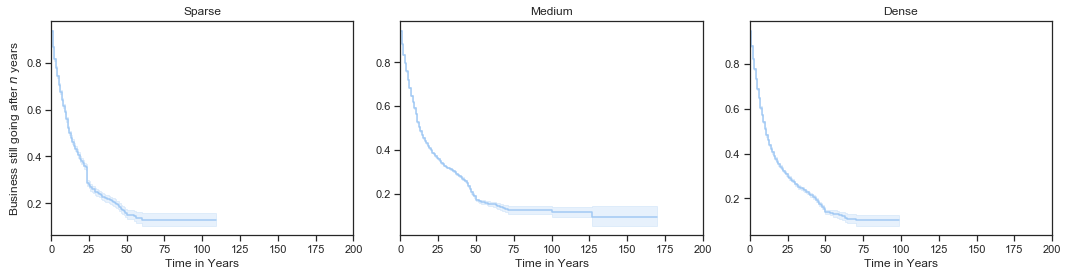

In [61]:
fig = plt.figure(figsize=(15,4))

for i, size in enumerate(n_size):
    #ax = plt.subplot(2, 3, i + 1)
    #ax = plt.subplot(1, 1, i+1)
    ax = plt.subplot(1,3, i+1)
    ix = df['neighborhood_size'] == size

    #debug
    #print(f'length of T[ix]: {len(T[ix])} ')
    
    kmf.fit(T[ix], E[ix], label=size)
    #kmf.fit(T[ix], E[ix])

    kmf.plot(ax=ax, legend=False)
    plt.title(size)
    plt.xlim(0, 200)
    ax.set_xlabel("Time in Years")
    if i==0:
        plt.ylabel('Business still going after $n$ years')
        
plt.tight_layout()

Ok, so we are getting somewhere.  This tells us that businesses in neighborhoods with medium density tend to have longer lifespans.

In [62]:
df = pd.read_csv('../tmp/reg_bus_sfonly_modeling_data_stg2_asof20190515.csv', low_memory = False)

<h3> Cox Proportional Hazard Model 

This section applies the CoxPHFitter to the business dataset. The benefit of this model is that it can incorporate multiple features and make predictions. There are few features in this dataset, but I am interested in seeing what predictive value they have in the scope of full dataset, which encompasses almost 200 years worth of data. The additional features I have gathered are not available for that time frame, so I constructed a subset of recent businesses, added those features, and perform CoxCPH on that dataset in the notebook entitled 2.2 Survival Analysis on Recent. 

<h4>Transform Categorical Variables

In [63]:
#Transform the category column into numeric data so it can be used as a predictor.
df['category'] = df.apply(lambda row: 1 if row.neighborhood_size == 'Sparse' else
                               (2 if row.neighborhood_size == 'Medium' else 3), axis=1)
#check that it worked.
df.head()

,zip,certificate_number,city,dba_name,full_business_address,lic,lic_code_description,location,mail_city,mail_state,...,dur,status,new_neighborhood,neighborhood_size,size_rank,naic,lifetime,lifetime_qtrs,observed,category
0,94123.0,28,San Francisco,3101 Laguna Apts,3101 Laguna St,.,.,"{'latitude': '37.799823', 'longitude': '-122.4...",San Francisco,CA,...,103,open,Marina,Medium,1124,5300,26,103,0,2
1,94116.0,52,San Francisco,Ideal Novak Corp,8 Mendosa Ave,.,.,"{'latitude': '37.748926', 'longitude': '-122.4...",San Francisco,CA,...,202,open,West of Twin Peaks,Medium,0,5300,51,202,0,2
2,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,102,closed,Marina,Medium,1124,.,25,102,1,2
3,94123.0,71,San Francisco,3301 Broderick Apartments,3301 Broderick St,.,.,"{'latitude': '37.800876', 'longitude': '-122.4...",San Francisco,CA,...,102,closed,Marina,Medium,1124,.,25,102,1,2
4,94133.0,86,San Francisco,1601 Grant Apts,1601 Grant Ave,.,.,"{'latitude': '37.801724', 'longitude': '-122.4...",NaN,NaN,...,190,closed,North Beach,Medium,5770,.,48,190,1,2


In [64]:
#save again
df.to_csv('../tmp/reg_bus_sfonly_modeling_data_stg3_asof20190513.csv', index=False)

In [65]:
df = pd.read_csv('../tmp/reg_bus_sfonly_modeling_data_stg3_asof20190513.csv', low_memory = False)

In [66]:
df.columns

Index(['zip', 'certificate_number', 'city', 'dba_name',
       'full_business_address', 'lic', 'lic_code_description', 'location',
       'mail_city', 'mail_state', 'mail_zipcode', 'mailing_address_1',
       'naic_code', 'naic_code_description', 'neighborhood', 'ownership_name',
       'parking_tax', 'state', 'supervisor_district',
       'transient_occupancy_tax', 'ttxid', 'dba_start', 'dba_end', 'loc_start',
       'loc_end', 'lat', 'lon', 'y_start', 'q_start', 'yq_start', 'y_end',
       'q_end', 'yq_end', 'dur', 'status', 'new_neighborhood',
       'neighborhood_size', 'size_rank', 'naic', 'lifetime', 'lifetime_qtrs',
       'observed', 'category'],
      dtype='object')

Select Features for input to the model

In [67]:
newdf = df[['lifetime', 'observed', 'category', 'size_rank', 'naic']]
newdf.head()


,lifetime,observed,category,size_rank,naic
0,26,0,2,1124,5300
1,51,0,2,0,5300
2,25,1,2,1124,.
3,25,1,2,1124,.
4,48,1,2,5770,.


In [68]:
newdf_qtrs = df[['lifetime_qtrs', 'observed', 'category', 'size_rank', 'naic']]
newdf_qtrs.head()


,lifetime_qtrs,observed,category,size_rank,naic
0,103,0,2,1124,5300
1,202,0,2,0,5300
2,102,1,2,1124,.
3,102,1,2,1124,.
4,190,1,2,5770,.


In [69]:
#save temp
newdf.to_csv('../tmp/lifetime_yrs_stg1_asof20190513.csv', index=False)
newdf_qtrs.to_csv('../tmp/lifetime_qtrs_stg1_asof20190513.csv', index=False)

Fit the model and print summary information.
Using 'strata' to stratify on categorical values. One hot encoding this variable resulted in a matrix that was not invertible. To use it as a feature I would have to experiment with dropping multiple of the columns. The documentation suggested using strata as a way to include variables with this issue. The long-term solution is to do a more purposeful transformation of the naic codes.

In [70]:
cph = CoxPHFitter()
cph.fit(newdf, 'lifetime', event_col='observed', strata='naic')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 194826 observations, 108662 censored>
      duration col = 'lifetime'
         event col = 'observed'
            strata = naic
number of subjects = 194826
  number of events = 86164
    log-likelihood = -821190.50
  time fit was run = 2019-05-19 01:25:27 UTC

---
           coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
category   0.04      1.04      0.01 6.38 <0.005     32.38        0.03        0.05
size_rank  0.00      1.00      0.00 1.19   0.23      2.09       -0.00        0.00
---
Concordance = 0.50
Log-likelihood ratio test = 40.90 on 2 df, -log2(p)=29.51


The p-values for both category and size_rank are below the threshold, which means we can reject the null hypothesis that these features have no predictive value.  

The exp(coef) is the hardard ratio (HR.) A coef > 0, or a HR of > 1 indicated that as that covariate increases, the event harzard increases and the length of survival decreases.

To get more precision from the summary function, we can use the decimals= parameter

In [71]:
cph.print_summary(decimals=6)

<lifelines.CoxPHFitter: fitted with 194826 observations, 108662 censored>
      duration col = 'lifetime'
         event col = 'observed'
            strata = naic
number of subjects = 194826
  number of events = 86164
    log-likelihood = -821190.500487
  time fit was run = 2019-05-19 01:25:27 UTC

---
              coef exp(coef)  se(coef)        z        p  -log2(p)  lower 0.95  upper 0.95
category  0.041503  1.042376  0.006507 6.378224   <5e-07 32.378086    0.028749    0.054256
size_rank 0.000003  1.000003  0.000002 1.188394 0.234678  2.091245   -0.000002    0.000008
---
Concordance = 0.503626
Log-likelihood ratio test = 40.904072 on 2 df, -log2(p)=29.506051


Now we can see by how much the expected survival rate decreases with the increase of each variable.

Let's try it with the time intveral being in quarter instead of years.

In [72]:
cph = CoxPHFitter()
cph.fit(newdf_qtrs, 'lifetime_qtrs', event_col='observed', strata='naic')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 194826 observations, 108662 censored>
      duration col = 'lifetime_qtrs'
         event col = 'observed'
            strata = naic
number of subjects = 194826
  number of events = 86164
    log-likelihood = -818942.07
  time fit was run = 2019-05-19 01:25:29 UTC

---
           coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
category   0.04      1.04      0.01 6.14 <0.005     30.16        0.03        0.05
size_rank  0.00      1.00      0.00 1.03   0.30      1.71       -0.00        0.00
---
Concordance = 0.50
Log-likelihood ratio test = 38.00 on 2 df, -log2(p)=27.41


In [73]:
cph.print_summary(decimals=6)

<lifelines.CoxPHFitter: fitted with 194826 observations, 108662 censored>
      duration col = 'lifetime_qtrs'
         event col = 'observed'
            strata = naic
number of subjects = 194826
  number of events = 86164
    log-likelihood = -818942.073434
  time fit was run = 2019-05-19 01:25:29 UTC

---
              coef exp(coef)  se(coef)        z        p  -log2(p)  lower 0.95  upper 0.95
category  0.039998  1.040809  0.006516 6.138487   <5e-07 30.160771    0.027227    0.052769
size_rank 0.000003  1.000003  0.000002 1.026401 0.304703  1.714526   -0.000002    0.000007
---
Concordance = 0.503057
Log-likelihood ratio test = 37.998981 on 2 df, -log2(p)=27.410470



The results are very similar. 
The next step is to run the Survival Analysis on the subset of recent business (those that began during the time period starting in 2000-Q1,) with additional predictors. see notebook 3.2 for that anlysis. 

Below we calculate and plot residuals from the quarters version of this model for which to compare. This was based on examples from the Lifelines package documentation.


In [74]:
r = cph.compute_residuals(newdf_qtrs, 'martingale')
r.head()

,lifetime_qtrs,observed,martingale
294,0.0,True,0.967112
4580,0.0,True,0.966263
5710,0.0,True,0.967494
7324,0.0,True,0.967112
8375,0.0,True,0.966243


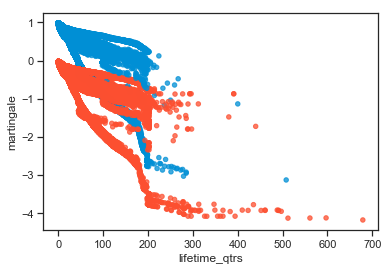

In [75]:
r.plot.scatter(
    x='lifetime_qtrs', y='martingale', c=np.where(r['observed'], '#008fd5', '#fc4f30'),
    alpha=0.75
);

From the Lifelines docs:  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Cox%20residuals.html

One problem with martingale residuals is that they are not symetric around 0. Deviance residuals are a transform of martingale residuals them symetric.

-  Roughly symmetric around zero, with approximate standard deviation equal to 1.
-  Positive values mean that the patient died sooner than expected.
-  Negative values mean that the patient lived longer than expected (or were censored).
-  Very large or small values are likely outliers.



In [76]:
r = cph.compute_residuals(newdf_qtrs, 'deviance')
r.head()

,lifetime_qtrs,observed,deviance
294,0.0,True,2.212487
4580,0.0,True,2.201315
5710,0.0,True,2.217583
7324,0.0,True,2.212487
8375,0.0,True,2.201056


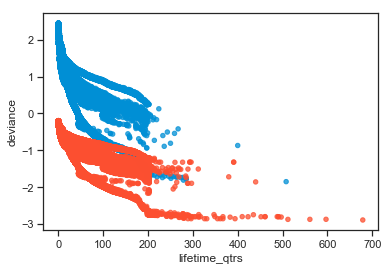

In [77]:
r.plot.scatter(
    x='lifetime_qtrs', y='deviance', c=np.where(r['observed'], '#008fd5', '#fc4f30'),
    alpha=0.75
);

In [78]:
r = r.join(newdf_qtrs.drop(['lifetime_qtrs', 'observed'], axis=1))

In [79]:
r.head()

,lifetime_qtrs,observed,deviance,category,size_rank,naic
294,0.0,True,2.212487,2,5770,.
4580,0.0,True,2.201315,3,0,.
5710,0.0,True,2.217583,2,1124,.
7324,0.0,True,2.212487,2,5770,.
8375,0.0,True,2.201056,3,235,.


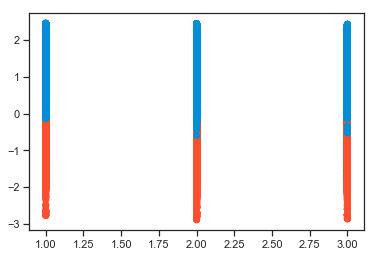

In [80]:
plt.scatter(r['category'], r['deviance'], color=np.where(r['observed'], '#008fd5', '#fc4f30'));

In [81]:
r = cph.compute_residuals(newdf_qtrs, 'delta_beta')
r.head()

,category,size_rank
294,-0.004995,-0.000007
4580,-0.038531,-0.000057
5710,-0.032018,-0.000048
7324,-0.004994,-0.000007
8375,-0.037165,-0.000055


In [82]:
r = r.join(newdf_qtrs[['lifetime_qtrs', 'observed']])
r.head()

,category,size_rank,lifetime_qtrs,observed
294,-0.004995,-0.000007,0,1
4580,-0.038531,-0.000057,0,1
5710,-0.032018,-0.000048,0,1
7324,-0.004994,-0.000007,0,1
8375,-0.037165,-0.000055,0,1


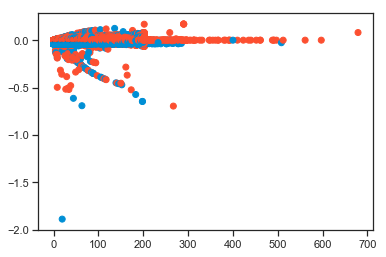

In [83]:
plt.scatter(r['lifetime_qtrs'], r['category'], color=np.where(r['observed'], '#008fd5', '#fc4f30'));

In [84]:
#cph = CoxPHFitter().fit(newdf_qtrs, 'T', 'E')
censored_subjects = newdf.loc[newdf['observed'] == 0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)

conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[newdf.loc[c.name, 'lifetime']]).clip_upper(1))

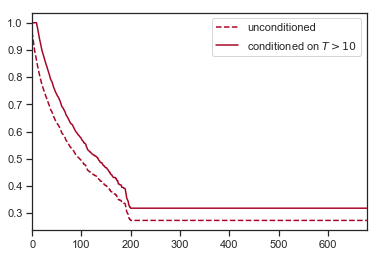

In [85]:
# Try to predict a single subject
subject = 87  #random pick
unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>10$")
plt.legend()